In [336]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import requests
import json
from jsonmerge import merge
import glob
import seaborn as sns
import geopandas
from zipfile import ZipFile

In [418]:
stations = pd.read_csv("policestations.csv")
reports = pd.read_csv("Police_Incident_Reports.csv")

In [419]:
reports['Victim'].value_counts()  ## Look at Ages
reports['Arrested'].values  ## Maybe look at the ages

array(['                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ',
       'Tony R Markovitch, 20 years old, 301 Knutson Dr, Madison, WI\r\r\nCharges:  Operating Motor Vehicle While Intoxicated, Operating After Revocation, Endangering Safety by Use of a Dangerous Weapon (Going Armed While Intoxicated), Carrying Concealed Weapon, and Possession of a Firearm by a Felon.                                                                                       

In [420]:
get_year = reports['IncidentDate'].values
years = []
datetimes = []
for i, element in enumerate(get_year):
    year = element[0:4]
    month = element[5:7]
    day = element[8:10]
    years.append(int(year))
    datetimes.append(datetime.date(int(year), int(month), int(day)))
reports["Year"] = years
reports['Datetime'] = datetimes

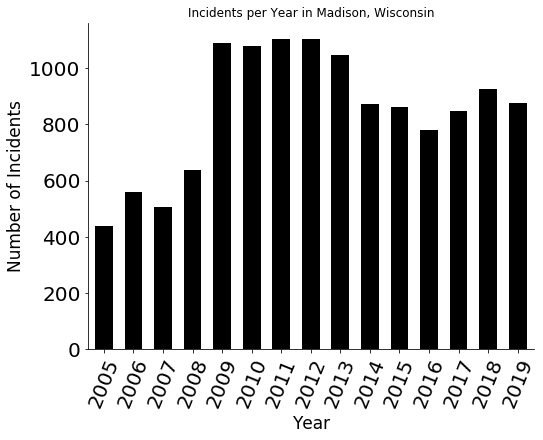

In [421]:
fig, axis = plt.subplots()
years = reports['Year'].value_counts()
filtyears = years[years > 250].sort_index(ascending = True) ## Got Rid of 2020 for now, and one with only one
filtyears.plot.bar(ax = axis, figsize = (8,6),
                   title = "Incidents per Year in Madison, Wisconsin", 
                   fontsize = 20,
                   color = "Black", width = 0.6)
axis.set_ylabel('Number of Incidents', fontsize = 17)
axis.set_xlabel("Year" ,fontsize = 17)
axis.spines['right'].set_visible(False)
axis.spines['top'].set_visible(False)
axis.set_xticklabels(labels = axis.get_xticklabels(), rotation = 68)
None

In [422]:
valid_years= [2005, 2019]
times = reports["Datetime"].values
months = [(date.year,date.month) for date in times]
reports["month"] = months

smonths = reports['month'].value_counts()

month_countsdyear =smonths.to_dict()
month_counts= {}
for month in month_countsdyear:
    if month[1] in month_counts:
        month_counts[month[1]]+= month_countsdyear[month]
    else:
        month_counts[month[1]] = month_countsdyear[month]
#month_counts

In [8]:
with open("Locationapikey.txt") as f:
    code = str(f.read())
def location_api(address):
    address += " Madison WI"
    encoded_address = address.replace(" ", "+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(encoded_address, code)
    r = requests.get(url)
    r.raise_for_status()
    location = r.json()
    return location['results'][0]['geometry']['location']
#addy = location_api("500 block State Street (Buckeye Parking Lot/Near Uno's pizza restaurant")

In [414]:
under2012 = reports[reports['Year'] <= 2012] ### Split up the data proccessing equally

In [415]:
all_address = under2012['Address'].value_counts().index.to_list()
c_address = []
for addy in all_address:
    corrected = addy.lstrip().rstrip()
    c_address.append(corrected)
print(len(c_address))

5575


In [424]:
#location_lat = {}
#incorrect_i = []
#for address_index in range(len(c_address)):
#    last_i = address_index
#    address = c_address[address_index]    ## Only use this to scrape the location of each address
#    try:                                  ## Have a google cloud account in order to use the geocode api
 #       location = location_api(address)
 #       location_lat[address] = location
 #   except:
 #       incorrect_i.append(address)
 #   if last_i % 100 == 0:
 #       print(last_i)
 #  if last_i >= 5576:
 #       break

#print(last_i)
#with open('location2011A.json', 'w') as f:
#    json.dump(location_lat, f)

In [425]:
#location = location_api(incorrect_i[0][:16])  ## Use this to if incorrect_i has something in it
#location_lat[incorrect_i[0]] = location

In [411]:
#result = []   ## FOR JOINING, BUT because you already have json move stuff around
#for f in glob.glob("*.json"):       ## Taken forom unutbu
#    with open(f, "rb") as infile:   ##https://stackoverflow.com/questions/23520542/issue-with-merging-multiple-json-files-in-python
#        result.append(json.load(infile))
#full_dict = {**result[0], **result[1], **result[2], **result[3]}
#print(len(full_dict))

In [410]:
with open("lat_lon.json") as f:
    lat_lon = json.load(f)
#lat_lon

In [237]:
i = 0
not_in = 0
lat_list = []
for row in zip(reports['Address']):
    address = row[0].lstrip().rstrip()
    if address in lat_lon:
        lat = lat_lon[address]['lat']
        lon = lat_lon[address]['lng']
        tup = (lat, lon)
        lat_list.append(tup)
    else:
        lat_list.append((None, None))
        not_in +=1

In [240]:
lats= []
lons = []
for coord in lat_list:
    lats.append(coord[0])
    lons.append(coord[1])

In [263]:
reports['Lat'] = lats
reports['Lon'] = lons

In [426]:
reports ## Added columns for easier analysis

,IncidentID,IncidentType,CaseNumber,IncidentDate,Suspect,Arrested,Address,Victim,Details,ReleasedBy,DateModified,Year,Datetime,month
0,7400,Assist Outside Agency,2005-13680 ...,2005-10-07T03:33:00.000Z,NaN,...,700 Block of E. Washington Ave. ...,...,On 2/6/05 at approximately 10:33 p.m. Officer ...,Mike Hanson,NaN,2005,2005-10-07,"(2005, 10)"
1,7401,Arrested Person,2005-22647 ...,2005-03-03T05:42:00.000Z,NaN,"Tony R Markovitch, 20 years old, 301 Knutson D...",First St & E Washington Ave ...,n/a ...,"At approximately 11:42 pm, an officer noted a ...",Lt Pat Malloy,NaN,2005,2005-03-03,"(2005, 3)"
2,7402,Arrested Person,2005-22345 ...,2005-03-02T14:30:00.000Z,NaN,Martell D. Britton m/b 05-03-85\r\r\nCharge: ...,8 New Berm Court ...,Home Depot ...,"On 03/02/2005 at approximately 8:15 am, the Ma...",Lt. T. Peterson,NaN,2005,2005-03-02,"(2005, 3)"
3,7403,Arrested Person,2005-22688 ...,2005-03-03T13:30:00.000Z,NaN,"Twainesse L Peavy, 26 yrs old, 2317 Fish Hatch...",4300 Lumley Rd ...,Adult male resident of Madison ...,"At approximately 7:30 am this date, Officers r...",Lt. Pat Malloy,NaN,2005,2005-03-03,"(2005, 3)"
4,7404,Information,2005-999999 ...,2005-03-04T19:45:00.000Z,NaN,...,211 S. Carroll Street ...,...,DELIVERY NOTICES FOR UNPAID PARKING TICKETS\r\...,Lieutenant Joe Balles,NaN,2005,2005-03-04,"(2005, 3)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12985,24262,Weapons Violation,2020-27849,2020-01-21T15:55:00.000Z,NaN,NaN,30 Ash Street,NaN,West High’s School Resource Officer received i...,PIO Joel Despain,NaN,2020,2020-01-21,"(2020, 1)"
12986,24263,Arrested Person,2020-27717,2020-01-21T14:07:00.000Z,NaN,NaN,Morrow Court,NaN,&nbsp;&nbsp;&nbsp;&nbsp; A community member al...,PIO Joel Despain,NaN,2020,2020-01-21,"(2020, 1)"
12987,24264,Robbery,2020-28952,2020-01-22T05:04:00.000Z,NaN,NaN,636 W. Washington Ave.,NaN,"Last night, a woman who claimed she had an acc...",PIO Joel Despain,NaN,2020,2020-01-22,"(2020, 1)"
12988,24265,Robbery,2020-00030403,2020-01-23T03:30:00.000Z,NaN,"Gavin P. McGinnis, age 20\r\nArrested for arme...",400 block E Johnson St,NaN,Officers were dispatched to the 400 block E Jo...,Sgt. Benjamin Schwarz,2020-01-23T18:17:36.000Z,2020,2020-01-23,"(2020, 1)"


In [409]:
top = (43.172605, -89.377590)
right = (43.097444, -89.244037)
bottom = (42.999345, -89.497066)
left = (43.060581, -89.561954)   ## Used this to censor down on possible data due to error in reading

lat_max = [42.999345, 43.172605]
lon_max = [-89.561954,  -89.244037]

### To work on
 + Heat Map of the city,
 + Overall city
 + How crime has changed throughout the years
 + How far is the average crime from the nearest police station.
 + Graph comparing to Police Stations
 + Affect of College Population Leaving where does crime occur


### Languague Processing
+ What type of arrest?
+ Times? - use mean times, for difference if coule be analyzed

In [403]:
Lakes = geopandas.read_file("Lakes")
City = geopandas.read_file("City_Limits")
Streets = geopandas.read_file("Street_Centerlines")
Parks = geopandas.read_file("Parks")
#stations = pd.read_csv("policestations.csv")

In [408]:
with open("Location_Years.csv") as f:
    location = pd.read_csv(f)
df = location[['Lat', "Lon"]]

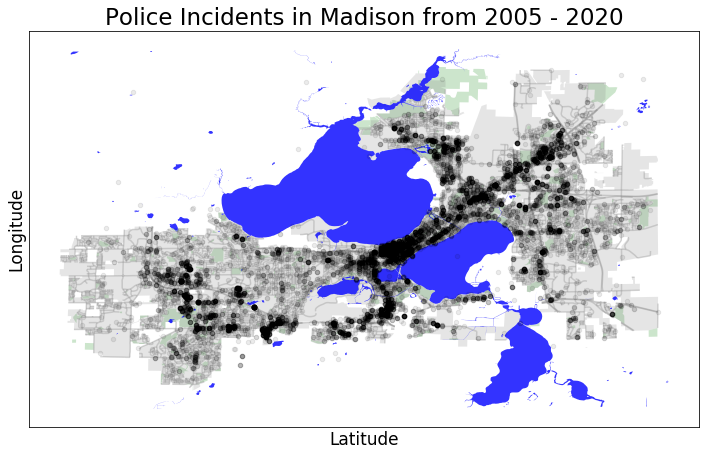

In [407]:
fig,ax = plt.subplots(figsize=(12, 12))
df.plot.scatter(x = 'Lon', y = 'Lat',ax = ax, alpha = 0.08, color = "Black", zorder = 2)
Lakes.plot(color="blue", alpha=0.8, zorder=1,ax = ax)
Streets.plot(color = 'gray', alpha = 0.3, zorder = 0, ax = ax)
City.plot(color = 'grey', alpha = 0.2, zorder =-1, ax = ax)
Parks.plot(color = 'green', alpha = 0.2, zorder = -2, ax = ax)
ax.set_title("Police Incidents in Madison from 2005 - 2020", fontsize = 23)
ax.set_ylabel('Longitude', fontsize = 17)
ax.set_xlabel('Latitude', fontsize = 17)

# Turn off tick labels
ax.set_yticklabels([]) # https://stackoverflow.com/questions/37039685/hide-axis-values-but-keep-axis-tick-labels-in-matplotlib
ax.set_xticklabels([]) # taken from tmdavison
ax.set_xticks([], minor = False)
ax.set_yticks([], minor = False)
None